In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1Una8W3UjxkZkNY_zYgiQEl9eieA3fL_m?usp=share_link'
gdown.download_folder(url=url, quiet=False)

Retrieving folder list


Retrieving folder 1UqFFBN0jipiOnv3BMsR_b2x87kzgXHl4 .ipynb_checkpoints
Processing file 1UrJA8-pAqVUAg2SGUCMvqY7590ddHtIq 2017.nc
Processing file 1UtNsxGE5SG4mRBL0_oe0MA2CQRrX-pxk 2018.nc
Processing file 1Uu6yWje7XzgWotOuzOjAnDt-9YabhezQ 2019.nc
Processing file 1UuHXe_iHtgzwZRbmIMash0yA1L4WEhp5 2020.nc
Processing file 1Uun1A0H_XFv5Y0x_6CdNtLHkQgL8yaay 2021.nc
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1UrJA8-pAqVUAg2SGUCMvqY7590ddHtIq
To: /content/crop/2017.nc
100%|██████████| 29.5M/29.5M [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UtNsxGE5SG4mRBL0_oe0MA2CQRrX-pxk
To: /content/crop/2018.nc
100%|██████████| 29.5M/29.5M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uu6yWje7XzgWotOuzOjAnDt-9YabhezQ
To: /content/crop/2019.nc
100%|██████████| 29.5M/29.5M [00:00<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UuHXe_iHtgzwZRbmIMash0yA1L4WEhp5
To: /content/crop/2020.nc
100%|██████████| 29.5M/29.5M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uun1A0H_XFv5Y0x_6CdNtLHkQgL8yaay
To: /content/crop/2021.nc
100%|██████████| 29.5M/29.5M [00:00<00:00, 101MB/s] 
Download completed


['/content/crop/2017.nc',
 '/content/crop/2018.nc',
 '/content/crop/2019.nc',
 '/content/crop/2020.nc',
 '/content/crop/2021.nc']

In [ ]:
url = 'https://drive.google.com/file/d/1Q0X_s2-93vN5ZNwvEl0pqPyka6-Pivuv/view?usp=drive_link'
output = 'idata_logit.nc'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Q0X_s2-93vN5ZNwvEl0pqPyka6-Pivuv
To: /content/idata_logit.nc
100%|██████████| 144M/144M [00:00<00:00, 255MB/s]


'idata_logit.nc'

# imports

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd

import pymc as pm
import arviz as az
import pytensor as pt

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pm.__version__

'5.1.2'

In [ ]:
RANDOM_SEED = 5434
rng = np.random.default_rng(RANDOM_SEED)

az.style.use('arviz-darkgrid')

# data

In [ ]:
def get_df(path, start_date, end_date):
    df = xr.open_dataset(path).sel(
        time=slice(start_date, end_date)).to_dataframe()
    
    df = df.dropna()
    df.counts = np.where(df.counts > 0, 1, 0)
    df = df.astype({'counts': 'int32'})
    df = df.rename({'FWI': 'X1', 'forest_cover': 'X2', 'counts': 'y'}, axis=1)
    
    return df

In [ ]:
df_train = pd.concat(
    [get_df(f'crop/{year}.nc', f'{year}-5-01', f'{year}-10-31') 
    for year in range(2017, 2021)])
df_test = get_df(f'crop/2021.nc', '2021-5-01', '2021-10-31')

# model

In [ ]:
with pm.Model() as model:
    X1 = pm.MutableData('X1', df_train.X1)
    X2 = pm.MutableData('X2', df_train.X2)
    y = pm.MutableData('y', df_train.y)
    
    beta0 = pm.Normal('beta0', mu=-10, sigma=5)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=2, sigma=5)
    p = pm.invlogit(beta0 + beta1 * X1 + beta2 * X2)

    pm.Bernoulli('pred', p=p, observed=y)

# inference

In [ ]:
idata = az.from_netcdf('idata_logit.nc')
az.summary(idata)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-8.636,0.064,-8.754,-8.514,0.003,0.002,569.0,637.0,NaN
beta1,0.144,0.001,0.142,0.145,0.000,0.000,2728.0,2550.0,NaN
beta2,2.341,0.068,2.213,2.464,0.003,0.002,595.0,620.0,NaN


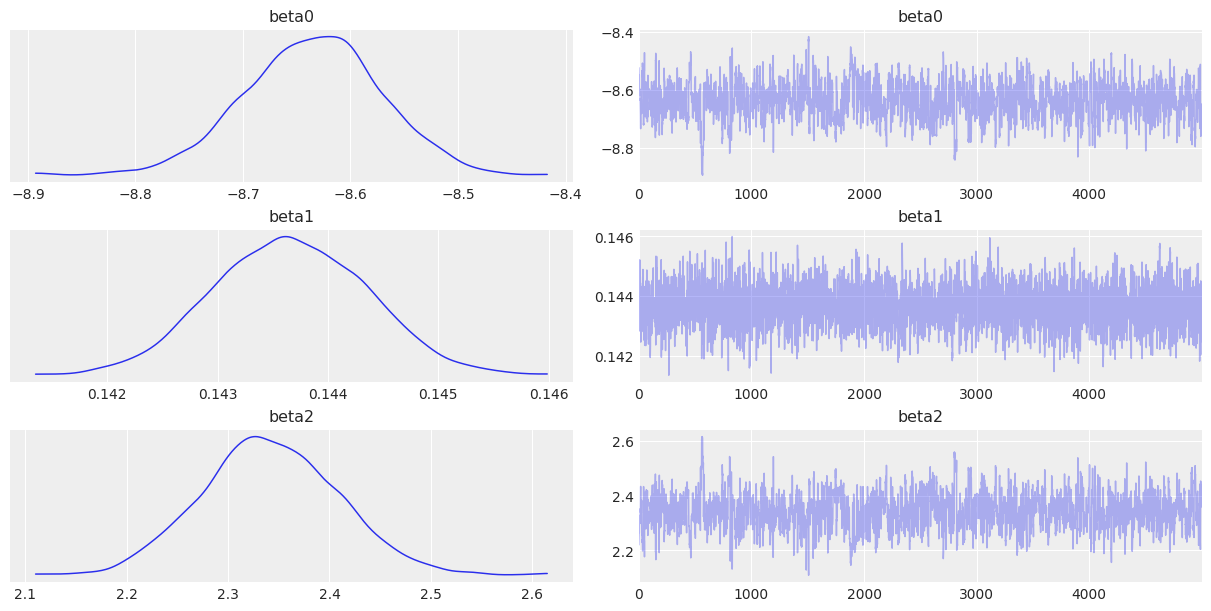

In [ ]:
az.plot_trace(idata)
plt.show()

# posterior

In [ ]:
with model:
    pm.set_data({'X1': df_test.X1,
                 'X2': df_test.X2,
                 'y': df_test.y})

    idata.extend(pm.sample_posterior_predictive(
        idata.posterior.sel(draw=slice(None, None, 50)),
        var_names=['pred'], random_seed=RANDOM_SEED,
        extend_inferencedata=True))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/Othercomputers/My MacBook Air/thesis'
idata.to_netcdf(f'{root}/model/glm/posterior_logit.nc')